First, lets import all necessary modules, including Matplotlib for plotting

Also, define parameters for plotting, including colors

In [1]:
import os
import sys
import math
import copy

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

from libra_py import units
import libra_py.workflows.nbra.step4 as step4
from libra_py import data_conv
import libra_py.workflows.nbra.qsh as qsh



import matplotlib.pyplot as plt   # plots
%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::complex<double>, std::allocator<std::complex<double> > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, s

Here is where we define our model. For this model, we can denerate the Hvib matrices along the pre-computed trajectories (the NBRA assumption). NBRA = neglect of back-reaction approximation. 

In this example, we only imagine a system evolving in time such that the adiabatic energies and non-adiabatic couplings are constant for all times - really the simplest model problem. Well, in reality, this may be not that simple to realise, but we don't care here.

We generate a single data set (one "trajectory") - that's why len(Hvib) == 1 

The trajectory comprises nsteps = 1000 nuclear timesteps

Adiabatic energy levels are at -0.001 and 0.001 a.u. and the NAC is at 0.001 a.u. as well

In [2]:
def gen_data(nsteps):
    rnd = Random()

    w1 = 100.0 * units.inv_cm2Ha  # in cm^-1
    w2 = 250.0 * units.inv_cm2Ha  # in cm^-1
    w3 = 300.0 * units.inv_cm2Ha  # in cm^-1
    dt = 1.0 * units.fs2au

    # Populate Hvib - this is our model
    Hvib = []
    hvib = []
    for i in range(nsteps):        
        hvib.append(CMATRIX(2,2))
    
        t = dt*i

        e0 = 0.001*math.sin(w1*t)
        e1 = 0.01 + 0.002*math.sin(w2*t) + 0.001*rnd.uniform(-1.0, 1.0)
        d  = 0.001  + 0.001*math.sin(w3*t) 

        hvib[i].set(0,0,e0*(1.0+0.0j));   hvib[i].set(0,1, d*(0.0-1.0j));
        hvib[i].set(1,0, d*(0.0+1.0j));   hvib[i].set(1,1, e1*(1.0+0.0j));
    Hvib.append(hvib)
        
    return Hvib

In [3]:
nsteps = 1000

Hvib = gen_data(nsteps)

In [4]:
params = {}

params["dt"] = 41.0  
params["nsteps"] = 1000 # total length of quasi-stochastical Ham
params["nfreqs"] = 25 # number of frequency included 

params["do_QSH_output"] = False


qsh_Hvib = qsh.run(Hvib, params)

In [5]:
T1 = []   # original
T2 = []   # reconstructed
for i in range(nsteps):
    T1.append(i*params["dt"])
for i in range(params["nsteps"]):    
    T2.append(i*params["dt"])

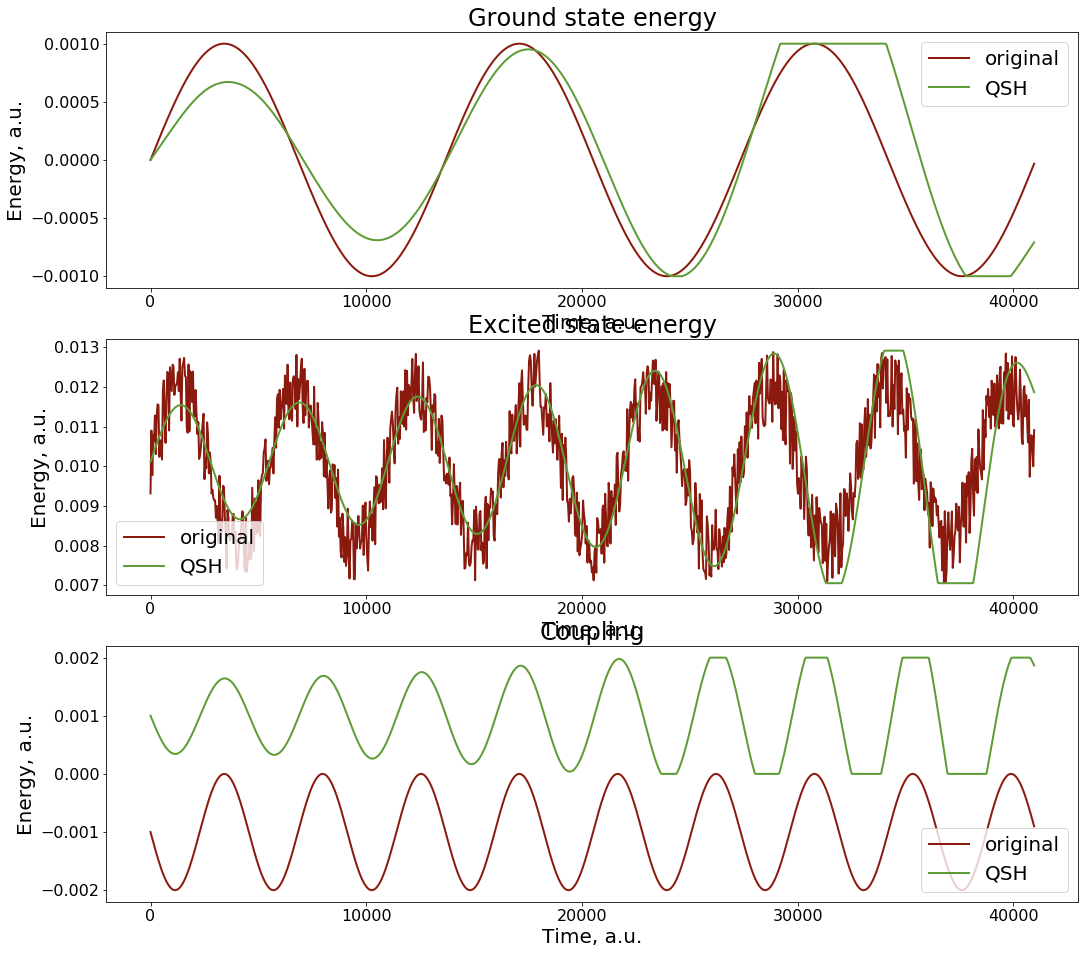

In [6]:
plt.figure(1, figsize=(18, 16)) # dpi=300, frameon=False)
plt.subplot(3,1,1)
plt.title('Ground state energy')
plt.xlabel('Time, a.u.')
plt.ylabel('Energy, a.u.')
plt.plot(T1, data_conv.unpack1(Hvib[0], 0, 0, 0), label='original', linewidth=2, color = colors["11"]) 
plt.plot(T2, data_conv.unpack1(qsh_Hvib[0], 0, 0, 0), label='QSH', linewidth=2, color = colors["21"]) 
plt.legend()

plt.subplot(3,1,2)
plt.title('Excited state energy')
plt.xlabel('Time, a.u.')
plt.ylabel('Energy, a.u.')
plt.plot(T1, data_conv.unpack1(Hvib[0], 1, 1, 0), label='original', linewidth=2, color = colors["11"]) 
plt.plot(T2, data_conv.unpack1(qsh_Hvib[0], 1, 1, 0), label='QSH', linewidth=2, color = colors["21"]) 
plt.legend()

plt.subplot(3,1,3)
plt.title('Coupling')
plt.xlabel('Time, a.u.')
plt.ylabel('Energy, a.u.')
plt.plot(T1, data_conv.unpack1(Hvib[0], 0, 1, 1), label='original', linewidth=2, color = colors["11"]) 
plt.plot(T2, data_conv.unpack1(qsh_Hvib[0], 0, 1, 1), label='QSH', linewidth=2, color = colors["21"]) 
plt.legend()


plt.show()
plt.close()

In [7]:
import libra_py.workflows.nbra.step4 as step4

In [8]:
#nsteps = 500
params1 = {}
params1.update({"T":300.0, "ntraj":1000, "sh_method":1, "decoherence_method":1, "dt":41.0})
params1.update({"nsteps":nsteps, "Boltz_opt":1})
params1.update({"istate":1, "init_times":[0], "outfile":"_out.txt"})
params1.update({"data_set_paths":[""]})

In [9]:
# nstates = 2 => n_cols = 2*3 + 5 = 11
#        0    1      2     3    4      5      6     7     8    9    10
# res =  t   E0, P_SE0, P_SH0, E1, P_SE1, P_SH1, E_SE, E_SH, P_SE, P_SH
res1 = step4.run(Hvib, params1)

Decoherence times matrix (a.u. of time):
Decoherence times matrix (fs):
Decoherence rates matrix (a.u.^-1):


In [10]:
# nstates = 2 => n_cols = 2*3 + 5 = 11
#        0    1      2     3    4      5      6     7     8    9    10
# res =  t   E0, P_SE0, P_SH0, E1, P_SE1, P_SH1, E_SE, E_SH, P_SE, P_SH
res2 = step4.run(qsh_Hvib, params1)

Decoherence times matrix (a.u. of time):
Decoherence times matrix (fs):
Decoherence rates matrix (a.u.^-1):


In [11]:
P0, P1 = [], []
qsh_P0, qsh_P1 = [], []

for i in range(nsteps):    
    P0.append(res1.get(i, 3))  # SH pop of state 0
    P1.append(res1.get(i, 6))  # SH pop of state 1

for i in range(params["nsteps"]):
    qsh_P0.append(res2.get(i, 3))  # SH pop of state 0
    qsh_P1.append(res2.get(i, 6))  # SH pop of state 1

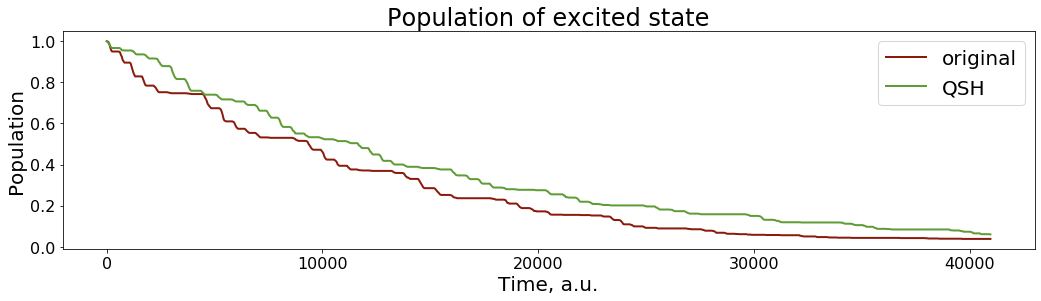

In [12]:
plt.figure(1, figsize=(18, 4)) # dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Population of excited state')
plt.xlabel('Time, a.u.')
plt.ylabel('Population')
plt.plot(T1, P1, label='original', linewidth=2, color = colors["11"]) 
plt.plot(T2, qsh_P1, label='QSH', linewidth=2, color = colors["21"]) 
plt.legend()

plt.show()
plt.close()